# SUPERWISE SDK: AI-Assistant Retrieval with Connected Knowledge Quickstart Notebook 🚀

## Welcome to SUPERWISE!

**SUPERWISE®** accelerates model development and deployment and enables model monitoring, observability, and seamless integration into broader solutions. No matter your background or experience with LLMs, SUPERWISE empowers you to apply the most efficient architectures to your data and gain valuable insights through natural language interfacing.

## This Starter Notebook Will Show How To:

- 📂 **Connect a Website as Context**: Easily import a website's content as powerful SUPERWISE knowledge for one or more of your agents.
- 🛠️ **Build AI-Assistant QA Apps**: Select a deployed model, build a custom prompt, and deploy an application.
- ❓ **Ask Questions on Your Knowledge**: Test your application with user requests in just a few lines of code.

## Let's Get Started!

## Load Libaries <a name="load-libraries"></a>
#### Prepare resources for our use of the SUPERWISE client

In [ ]:
!pip install superwise-api --quiet
import os, json, pandas as pd, requests
from datetime import datetime

from superwise_api.superwise_client import SuperwiseClient
from superwise_api.models.application.application import ModelLLM, ModelProvider, \
OpenAIModel, OpenAIModelVersion, OpenAIParameters, GoogleModelVersion, \
AnthropicModelVersion, BasicLLMConfig, OpenAIModel, OpenAIModelVersion, AIAssistantConfig
from superwise_api.models.tool.tool import ContextConfig, OpenAIEmbeddingModel, \
EmbeddingModelProvider, OpenAIEmbeddingModelVersion, UrlKnowledgeMetadata, ToolConfigKnowledge
from superwise_api.models.context.context import ContextDef

## Authentication <a name="authentication"></a>
#### First, let's authenticate with a SUPERWISE Client ID and Client Secret, which can be generated in the tenant settings.

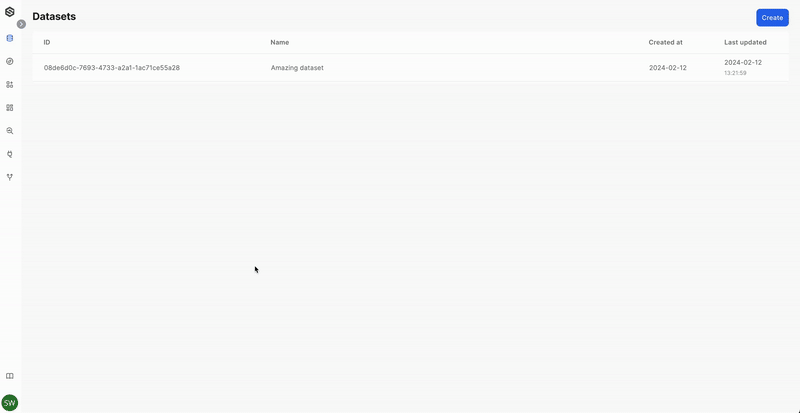

In [ ]:
os.environ['SUPERWISE_CLIENT_ID'] = ""
os.environ['SUPERWISE_CLIENT_SECRET'] = ""

try:
  sw = SuperwiseClient()
  print("Connection successful!")
except:
  print("Connection failed!")

## Model Provider and Version Options <a name="model-provider-and-version-options"></a>
#### We can select a model from a supported service provider listed here:

In [ ]:
#The following model providers are supported:
print("\n".join([provider.value for provider in ModelProvider]))

In [ ]:
#The following OpenAI models are currently offered:
openai_model_codes = [model_version.value for model_version in OpenAIModelVersion]
print("\n".join(openai_model_codes))

In [ ]:
#The following Google models are currently offered:
google_model_codes = [model_version.value for model_version in GoogleModelVersion]
print("\n".join(google_model_codes))

In [ ]:
#The following Anthropic models are currently offered:
google_model_codes = [model_version.value for model_version in AnthropicModelVersion]
print("\n".join(google_model_codes))

#### Note that private models in Google's Vertext AI Model Garden can also be deployed by way of providing:
- Project ID: Your unique Google Cloud Project identifier.
- Endpoint ID: The specific ID of the deployed model's endpoint.
- Location: The regional location of your deployed model.
- GCP Service Account: The credentials allowing SWE to access your hosted model. The service account should provide aiplatform.user permissions.

## SUPERWISE ASK Functions <a name="helper-functions"></a>

### ASK via API

In [ ]:
def ask_application_via_api(app_id, user_input, app_token, chat_history = []):
  endpoint_url = f"https://api.superwise.ai/v1/app-worker/{app_id}/v1/ask"

  payload = {
    "chat_history": chat_history,
    "input": user_input
  }

  headers = {
  "accept": "application/json",
  "content-type": "application/json",
  "x-api-token": app_token
  }

  resp = requests.post(endpoint_url, json=payload, headers = headers)
  app_response = resp.json()
  return app_response

### ASK via App Playground

In [ ]:
def ask_via_playground(app_id, user_input, chat_history = []):
  basic_app = sw.application.get_by_id(app_id)

  application_response = sw.application.ask_playground(input=user_input,
                                                       llm_model=basic_app.llm_model,
                                                       prompt=basic_app.prompt,
                                                       additional_config=basic_app.additional_config,
                                                       guards = basic_app.guards,
                                                       chat_history=chat_history)

  return application_response

## Create a New SUPERWISE Knowledge Source & Tool
#### In order to create a new knowledge source built on a public URL, we need to specify:

- Name: A meaningful name for the Knowledge that will help you and your teammates easily identify it. This name will be visible when connecting it with your application.
- Type: The type of knowledge input (URL).
- URL: The URL of the website you want to index. The information from this site will then be accessible within your application.
- Max Depth: The maximum number of links or levels, ranging from 1 to 5, that the crawler should follow from the initial page, limiting how deeply it explores the website’s structure.
- Embedding Model: A model for indexing your data within a vector database. This model converts the data into a searchable format, enabling efficient retrieval and utilization.

#### In this example, we'll build a knowledge source on the official site of SUPERWISE using GPT-4 small embeddings:

In [ ]:
openai_embedding_model=OpenAIEmbeddingModel(
  provider=EmbeddingModelProvider.OPEN_AI,
  version=OpenAIEmbeddingModelVersion.TEXT_EMBEDDING_3_SMALL,
  api_key="") ## Add an OpenAI API token here

In [ ]:
knowledge_source = sw.knowledge.create(name = "SUPERWISE Company Site Content", ## The knowledge source name that will be visible on the platform UI
                                       knowledge_metadata = UrlKnowledgeMetadata(type = "url",
                                                                                  url = "https://superwise.ai/", ## The base URL of the site whose context will be stored as knowledge
                                                                                  max_depth = 2), ## The maximum number of scraping "levels", ranging from 1 to 5
                                       embedding_model = openai_embedding_model) ## The model used to index the data as embeddings in the SUPERWISE knowledge source

#### Once this knowledge source has been loaded, it can be deployed in multiple applications within our tenant. We can build a knowledge tool for our website QA chatbot based on our new source:

In [ ]:
knowledge_context = ContextDef(
    name=f"SUPERWISE Company Web Content",
    config=ToolConfigKnowledge(
        knowledge_id=str(knowledge_source.id),
        knowledge_metadata=knowledge_source.knowledge_metadata,
        embedding_model=knowledge_source.embedding_model)
    )

## Create a SUPERWISE Website QA Chatbot (AI Assistant Application)

#### Create a Model

Given the [above options](#model-provider-and-version-options), we can select a model provider type and model version, including any API token credentials associated with our provider account.

In [ ]:
## In this case, our provider is OpenAI
model_version = "gpt-4-turbo" ## Choose from the list of models above
api_token = "" ## Provide an API key for the selected provider

## Running this cell will create an OpenAI model object for our new SUPERWISE application
model = OpenAIModel(version=model_version, api_token=api_token)

#### Adjust Model Parameters
We can adjust the model's creativity, output length, or frequency distribution by adjusting model parameters supported by the model provider. For example, if we wanted to make our loaded OpenAI model more deterministic, we can assign a low temperature through OpenAI's parameters:

In [ ]:
model = OpenAIModel(version=model_version, api_token=api_token, parameters=OpenAIParameters(temperature=0.5))

#### Create an Application

We can now build a simple company site QA chatbot:

In [ ]:
## This is a prompt engineering workspace.
sample_prompt = """I want you to act as a question answering customer support agent for the website of SUPERWISE, a leading provider of AI for the real world.
Given a user request about the company or the company website, you will answer the question with the help of the provided context from the company website.
Unless otherwise specified by the user in the information request, limit your response to 2 paragraphs or less. You may format your responses as markdown with bulleted or numbered lists, if appropriate.
If the question pertains to general knowledge, please return "I cannot answer that question".
If you cannot find any information relevant to answering the question, please return "I'm sorry, but I couldn't find enough information to answer this question."
"""

## This will be the application name that appears on the SUPERWISE UI.
application_name = "Company Website Chatbot Sample Application"

In [ ]:
## Running this cell will generate a new SUPERWISE application with the above sample prompt included.
try:
  app = sw.application.create(llm_model = model,
                              prompt = sample_prompt,
                              additional_config=AIAssistantConfig(context = knowledge_context),
                              name = application_name,
                              guards = [])

  app_config = {key: value.strftime("%Y-%m-%d %H:%M:%S") if isinstance(value, datetime) else str(value) for key, value in app.to_dict().items() if key in ["id", "created_at", "name", "dataset_id", "api_token"]}
  print(f"Application Created Successfully:\n{json.dumps(app_config, indent=4)}")
except Exception as e:
  print(f"Application Creation Unsuccessful. The Following Error Occurred:\n{e}")

#### And it's just that easy! You've created a new SUPERWISE application. We can test the model connection with a quick health check:

In [ ]:
try:
    sw.application.test_model_connection(model)
    print("Model test connection success!")
except Exception as e:
    print("Model test connection failed!")

## Test an Application

#### Now that we've configured our custom SUPERWISE application, we can test it in two ways:

In [ ]:
## Take this sample question:
user_input = "What does the company do?"

###### 1. We can use the SUPERWISE Application Playground in order to test the performance of various prompt and model options (custom SDK ASK function [here](#helper-functions)):

In [ ]:
application_response = ask_via_playground(str(app.id), user_input)
print(application_response.output)

###### 2. We can use the published application endpoint through a direct API call (custom API function [here](#helper-functions)):

In [ ]:
api_token = app_config["api_token"]

application_response = ask_application_via_api(str(app.id), user_input, api_token)
print(application_response.get("output"))

## Use an Existing SUPERWISE Application <a name="use-an-existing-superwise-application"></a>
#### Note that both of the above ASK functions can be applied on existing applications at any time. Here we'll learn how to use, modify, and delete applications in our SUPERWISE tenant with just a few lines of code.

### Find an Existing App

#### Method 1: GET by Application ID

In [ ]:
existing_app_id = f"{str(app.id)}" ## An Application ID from the SUPERWISE UI or sw.application.get().items
existing_app = sw.application.get_by_id(existing_app_id)

#### Method 2: Application Search by Configuration Criteria
- Name
- Created By
- Prompt
- Dataset ID

In [ ]:
existing_app = sw.application.get(name = app.name).items[0] # This search can be filtered on any of the above configuration resources

### Use an Existing App

In [ ]:
user_input = "What industries does SUPERWISE serve?"

###### For making requests to the app, we can either use the SUPERWISE App Playground (SDK)...

In [ ]:
application_response = ask_via_playground(existing_app.id, user_input)
print(application_response.output)

###### ...Or the API for published apps (custom API function [here](#helper-functions))

In [ ]:
application_response = ask_application_via_api(existing_app.id, user_input, str(existing_app.api_token))
print(application_response.get("output"))

## Modify Existing Application

##### Given our SUPERWISE chatbot, we can modify our application to include source-citing:

In [ ]:
existing_app = sw.application.put(str(existing_app.id),
                                  llm_model = existing_app.llm_model,
                                  prompt = existing_app.prompt,
                                  additional_config = existing_app.additional_config,
                                  name = existing_app.name,
                                  guards = existing_app.guards,
                                  show_cites = True)

#### Now, when answers are formulated, sources are included in the full response:

In [ ]:
application_response = ask_application_via_api(existing_app.id, user_input, str(existing_app.api_token))

In [ ]:
print(application_response["output"])

In [ ]:
print("\n".join([f"- {source}" for source in application_response["metadata"]["cite_sources"]]))

## Delete Existing Application

#### If, at any point, we no longer need our AI-Assistant application, it can always be deleted by app ID:

In [ ]:
try:
  sw.application.delete(existing_app.id)
  print("Application Deleted Successfully")
except Exception as e:
  print(f"Application Deletion Unsuccessful. The Following Error Occurred:\n{e}")